# Sample Siemens Analysis

In [1]:
import os
from pathlib import Path

In [2]:
# Change working path to the directory of the script
os.chdir(Path().cwd().parent)
Path.cwd()

PosixPath('/home/das/QuantUS_Projs/QuantUS')

# Select Image & Phantom and Parse

In [3]:
imagePath = Path("/media/das/CREST Data/David_S_Data/Thyroid_Analyzable/TRF01/uri_SpV1712_VpF512_FpA78_20190830131431.rfd")
phantomPath = Path("/media/das/CREST Data/David_S_Data/Thyroid_Analyzable/Phantom/uri_SpV2232_VpF512_FpA90_20210129103529.rfd")

In [4]:
from src.Parsers.siemensRfdParser import getImage

bmode, imgData, imgInfo, refData, refInfo = getImage(imagePath.name, f"{imagePath.parent}/", phantomPath.name, f"{phantomPath.parent}/")

# ROI Selection (from GUI)

In [5]:
import pickle

pkl_name = Path("/media/das/CREST Data/David_S_Data/Thyroid_Analyzable/Phantom/roi.pkl")

with open(pkl_name, 'rb') as f:
    roi_info = pickle.load(f)

In [6]:
assert roi_info["Image Name"] == imagePath.name
assert roi_info["Phantom Name"] == phantomPath.name

In [7]:
splineX = roi_info["Spline X"]
splineY = roi_info["Spline Y"]
frame = roi_info["Frame"]

# Analysis Config (from GUI)

In [8]:
from pyQus.analysisObjects import Config

pkl_name = Path("/media/das/CREST Data/David_S_Data/Thyroid_Analyzable/Phantom/analysis-config.pkl")

with open(pkl_name, "rb") as f:
    config_info = pickle.load(f)

In [9]:
assert config_info["Image Name"] == imagePath.name
assert config_info["Phantom Name"] == phantomPath.name

In [10]:
config = config_info["Config"]

# Spectral Analysis

In [11]:
from pyQus.analysisObjects import UltrasoundImage

ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfo.depth / imgData.rf[frame].shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgData.rf[frame].shape[0]/imgData.rf[frame].shape[1]
) # placeholder
ultrasoundImage.bmode = imgData.bMode[frame]
ultrasoundImage.phantomRf = refData.rf[0]
ultrasoundImage.rf = imgData.rf[frame]

In [12]:
from pyQus.spectral import SpectralAnalysis

spectralAnalysis = SpectralAnalysis()
spectralAnalysis.ultrasoundImage = ultrasoundImage
spectralAnalysis.config = config
spectralAnalysis.initAnalysisConfig()
spectralAnalysis.splineX = splineX
spectralAnalysis.splineY = splineY

In [13]:
spectralAnalysis.generateRoiWindows()
spectralAnalysis.computeSpecWindows()

# Visualizations

In [14]:
from src.DataLayer.spectral import SpectralData

spectralData = SpectralData()
spectralData.spectralAnalysis = spectralAnalysis

In [15]:
spectralData.convertImagesToRGB()

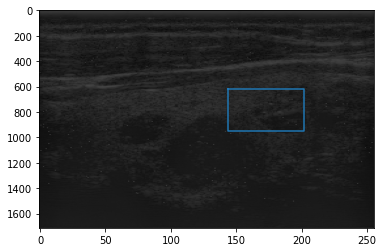

In [16]:
import matplotlib.pyplot as plt

plt.imshow(ultrasoundImage.bmode, aspect='auto')
plt.plot(splineX, splineY)

In [17]:
spectralData.drawCmaps()

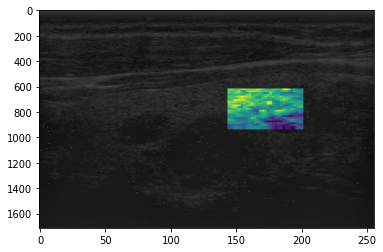

In [18]:
plt.imshow(spectralData.mbfIm, aspect='auto')

In [19]:
import numpy as np
np.mean(spectralData.mbfArr), np.mean(spectralData.siArr), np.mean(spectralData.ssArr)

(25.88452129734106, 55.98795057394216, -4.3017653385317456e-06)